# Expedia predict destination : 
The goal of this Kaggle competition is to predit the hotel of user

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from datetime import datetime
import xgboost as xgb
%matplotlib inline 

# Functions : 

In [2]:
def string_to_datetime(s, fmt='%Y-%m-%d'):
    if s != s:
        return np.nan
    year, month, day = s.split('-')
    try:  
        d = pd.datetime(int(year), int(month), int(day))
    except ValueError:
        d = pd.datetime(2017, 1, 1)
    d = min([max([d, pd.datetime(2013, 1, 1)]), pd.datetime(2017, 1, 1)])
    return d

# Explore and vizualise data : 

In [3]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv",nrows=180000)
destinations = pd.read_csv("destinations.csv")
submission = pd.read_csv("sample_submission.csv")
target = train.hotel_cluster

In [4]:
print "We have",train.shape[0], "train values and",train.shape[1],"variables and",test.shape[0],"test rows"

We have 180000 train values and 24 variables and 2528243 test rows


In [5]:
train.orig_destination_distance.fillna(0,inplace=True)
test.orig_destination_distance.fillna(0,inplace=True)

In [6]:
train['srch_ci'] = train['srch_ci'].apply(string_to_datetime)
train['srch_co'] = train['srch_co'].apply(string_to_datetime)
test['srch_ci'] = test['srch_ci'].apply(string_to_datetime)
test['srch_co'] = test['srch_co'].apply(string_to_datetime)

In [7]:
train['hotel_nights'] = train['srch_co'] - train['srch_ci']
test['hotel_nights'] = test['srch_co'] - test['srch_co']

In [8]:
train.hotel_nights.fillna(0,inplace=True)
test.hotel_nights.fillna(0,inplace=True)
train = train.drop('srch_ci',1)
train = train.drop('srch_co',1)
test = test.drop('srch_ci',1)
test = test.drop('srch_co',1)

In [9]:
train['hotel_nights'] = train.hotel_nights
train.hotel_nights = (train.hotel_nights / np.timedelta64(1, 'D')).astype(float)
test.hotel_nights = (test.hotel_nights / np.timedelta64(1, 'D')).astype(float)

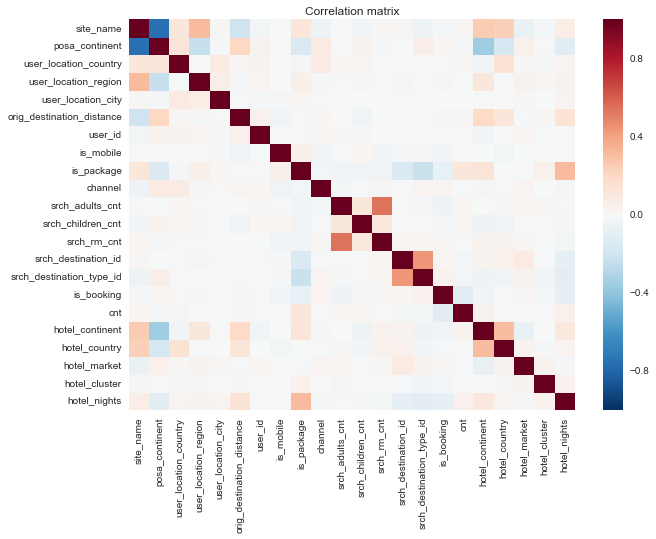

In [10]:
plt.figure(figsize=(10,7))
corr = train.corr()
sns.heatmap(corr)
plt.title("Correlation matrix")

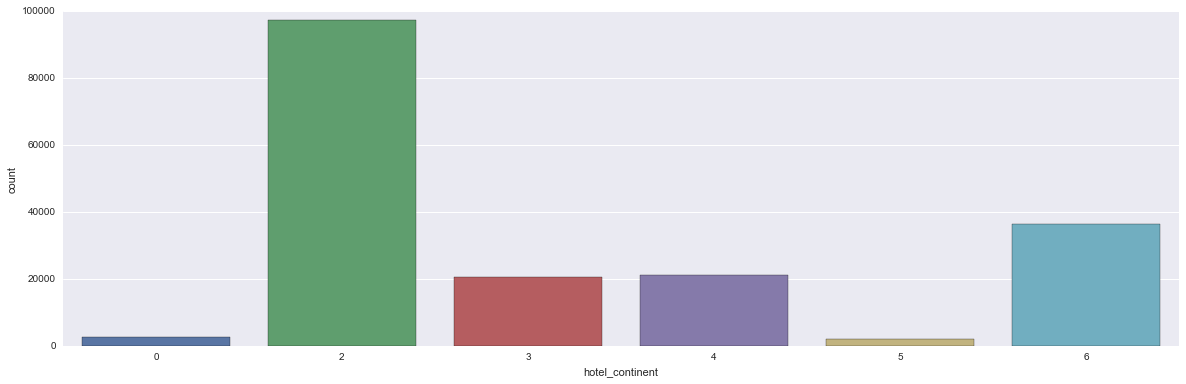

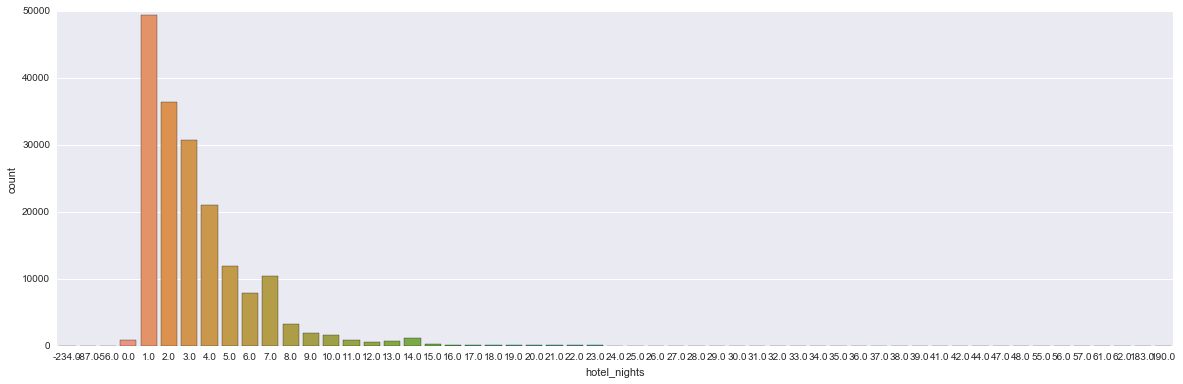

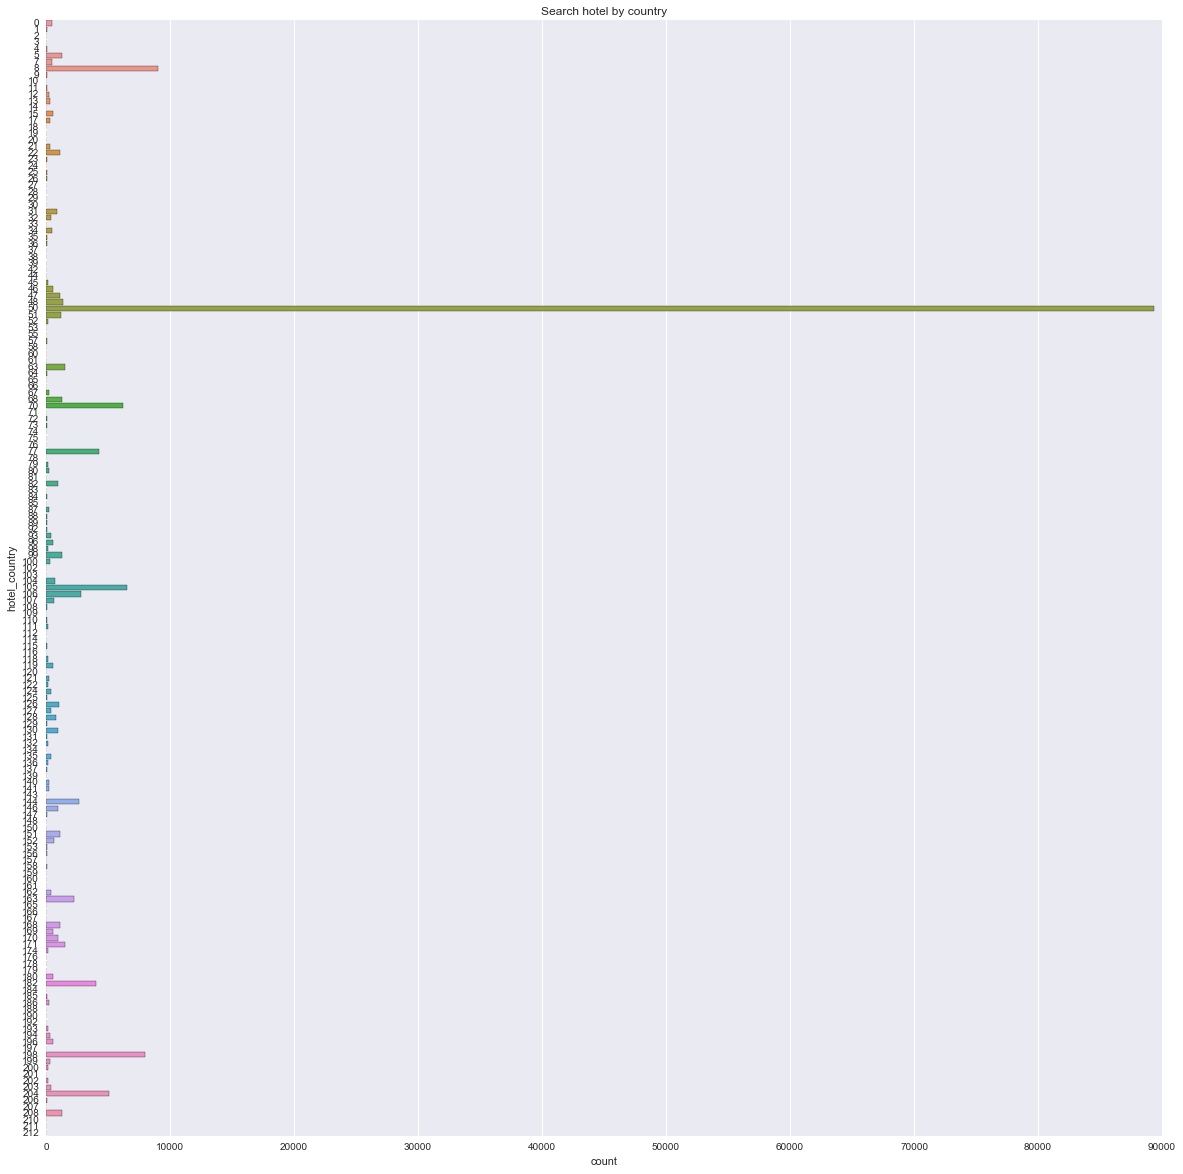

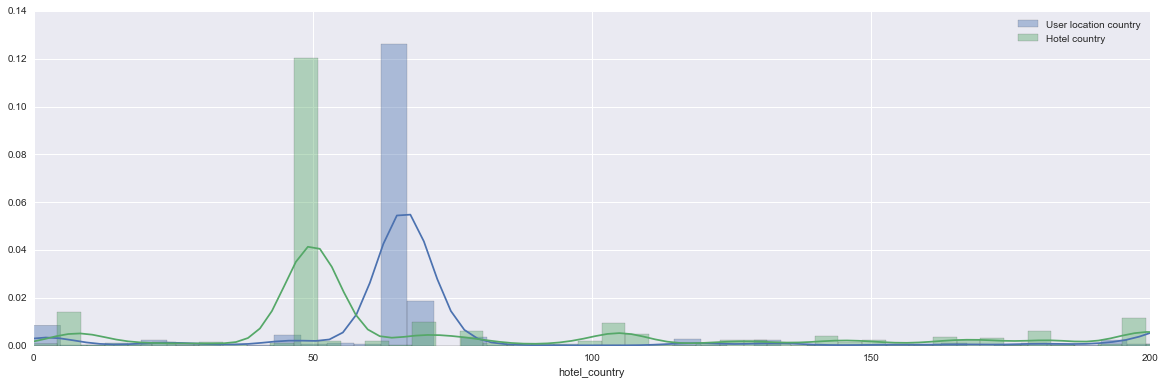

In [11]:
# Plot hotel continent histogram : 
plt.figure(figsize=(20,6))
sns.countplot(train.hotel_continent)

# Plot hotel cluster histogram : 
#plt.figure(figsize=(20,6))
#sns.countplot(train.hotel_cluster)

# Plot hotel nights histogram : 
plt.figure(figsize=(20,6))
sns.countplot(train.hotel_nights)

# Plot search hotel by country 
plt.figure(figsize=(20,20))
sns.countplot(y=train.hotel_country)
plt.title("Search hotel by country")

# Kde for user location country and hotel country
plt.figure(figsize=(20,6))
sns.distplot(train.user_location_country,label="User location country")
sns.distplot(train.hotel_country,label="Hotel country")
plt.xlim([0,200])
plt.legend()

We notice that most of booking is from continent 2, and the most reccurent hotel cluster is the cluster 91 and 41

The average of booking nights is :  3.35461111111  nights by user


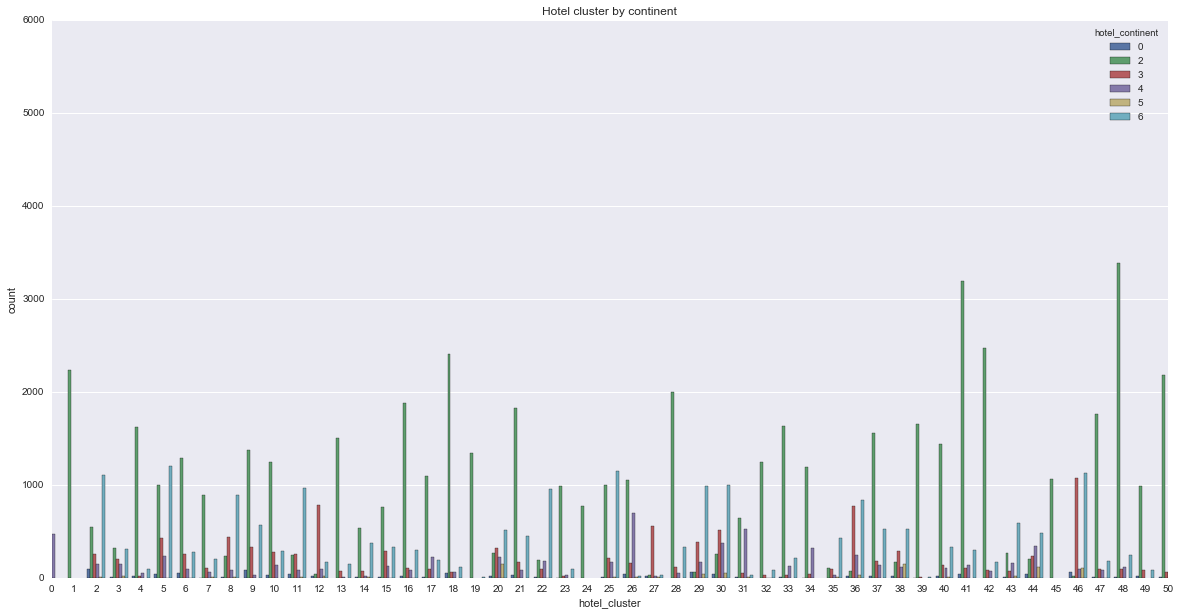

In [12]:
plt.figure(figsize=(20,10))
sns.countplot(x='hotel_cluster', hue='hotel_continent', data=train)
plt.title("Hotel cluster by continent")
plt.xlim([0,50])
print "The average of booking nights is : ",np.mean(train.hotel_nights)," nights by user"

In [13]:
columns = train.columns
for col in columns : 
    if(train[col].dtype !='object'):
        print col
        print(train[col].corr(train['hotel_cluster']))

site_name
-0.0196491531148
posa_continent
0.0050357084323
user_location_country
-0.0231487151424
user_location_region
0.008337511228
user_location_city
-0.00201986661764
orig_destination_distance
0.00995270767231
user_id
-0.00592058213861
is_mobile
-0.000104695503247
is_package
0.0529197695166
channel
-0.00110843588677
srch_adults_cnt
0.00817126118505
srch_children_cnt
0.00774881664269
srch_rm_cnt
-0.00662071055935
srch_destination_id
-0.0112645192326
srch_destination_type_id
-0.032275482266
is_booking
-0.0246723619026
cnt
0.00224706567311
hotel_continent
-0.00592476340749
hotel_country
-0.0234101046506
hotel_market
0.0333558513277
hotel_cluster
1.0
hotel_nights
0.0438724758395


In [14]:
train = train.drop('date_time',1)

In [15]:
lda = LDA(n_components = 2)
X_r = lda.fit(train,target).transform(train)
#pca = PCA(n_components = 2)
#X_r2 = pca.fit(train).transform(train)
#print('explained variance ratio (first two components): %s'% str(pca.explained_variance_ratio_))

/Users/aissaelouafi/Library/Python/2.7/lib/python/site-packages/sklearn/discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/Users/aissaelouafi/Library/Python/2.7/lib/python/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


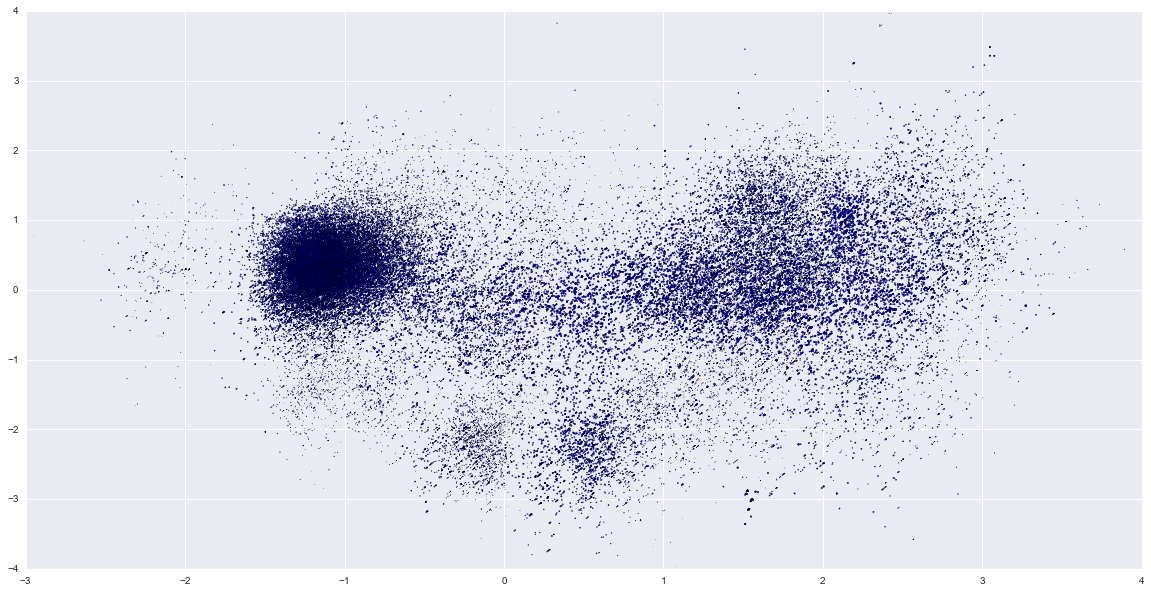

In [16]:
x = X_r[:,0]
y = X_r[:,1]
z = X_r[:,2]
plt.figure(figsize=(20,10))
plt.xlim([-3,4])
plt.ylim([-4,4])
plt.scatter(x, y, z)
plt.show()

In [17]:
test = test.drop('id',1)
test = test.drop('date_time',1)
train = train.drop('hotel_cluster',1)
train = train.drop('is_booking',1)
train = train.drop('cnt',1)

In [18]:
print "Train colmuns :",len(train.columns), "and test columns :",len(test.columns)

Train colmuns : 19 and test columns : 19


In [19]:
'''
model = RandomForestRegressor(n_estimators=100, min_samples_leaf=10,n_jobs=-1)
model.fit(train, target)
predicts = model.predict(test)
predicts = [ ceil(x) for x in predicts ]
predicts = [ int(x) for x in predicts ]
submission = pd.read_csv("sample_submission.csv")
submission["hotel_cluster"] = predicts
submission.to_csv("submission_rfc.csv", index=False)
rfs = pd.read_csv("submission_rfc.csv")
'''

'\nmodel = RandomForestRegressor(n_estimators=100, min_samples_leaf=10,n_jobs=-1)\nmodel.fit(train, target)\npredicts = model.predict(test)\npredicts = [ ceil(x) for x in predicts ]\npredicts = [ int(x) for x in predicts ]\nsubmission = pd.read_csv("sample_submission.csv")\nsubmission["hotel_cluster"] = predicts\nsubmission.to_csv("submission_rfc.csv", index=False)\nrfs = pd.read_csv("submission_rfc.csv")\n'

In [20]:
len(test.srch_destination_id.unique())

40718

In [21]:
len(destinations.srch_destination_id.unique())

62106

In [36]:
destinations
lda = PCA(n_components = 2)
X_PCA = lda.fit(destinations).transform(destinations)


# Build submission CSV file : 

In [22]:
model = RandomForestClassifier(n_jobs=-1)
model.fit(train, target)
predictsRF = model.predict(test)
#predictsRF = [ ceil(x) for x in predicts ]
#predictsRF = [ int(x) for x in predicts ]

In [23]:
submissionRF = pd.read_csv("sample_submission.csv")
submissionRF['hotel_cluster'] = predictsRF

In [24]:
submissionRF.to_csv("submissionRF.csv",index=False)